In [1]:

from osdatahub import FeaturesAPI, Extent, NGD
import geopandas as gpd
import folium
import matplotlib.pyplot as plt
import mapclassify as mc
from shapely.geometry import Point
import os
import numpy as np
from convertbng.util import convert_bng, convert_lonlat

from folium.plugins import measure_control

key = os.environ.get('OS_API_KEY')
crs = "EPSG:27700"

In [2]:
def OSparam_feature(u,v,rad,product,key,clip):
    extent = Extent.from_radius((u,v), rad, "EPSG:27700")
    features = FeaturesAPI(key, product, extent)
    results = features.query(limit=500)
    if len(results['features']) == 0:
        out = 0
    TA_gdf = gpd.GeoDataFrame.from_features(results['features'])

    if clip == True:
        patch = Point(u,v).buffer(rad)
        d = {'col1': ['name1'], 'geometry': [patch]}
        patch_df = gpd.GeoDataFrame(d, crs="EPSG:27700")
        TA_gdf = TA_gdf.clip(patch)
    try:
        gd = (TA_gdf['Theme'] == 'Buildings') & (~np.isnan(TA_gdf['RelH2']))
        out = np.average(TA_gdf['RelH2'][gd], weights=TA_gdf['Shape_Area'][gd])
    except TypeError:
        out = 0
    return out, TA_gdf



In [59]:
X = 180700.
Y = 44777.
radius = 50
clip = True
product = 'topographic_area'

In [4]:
def building_height_radius(X, Y, radius,product,key, clip):
    area, TA = OSparam_feature(X, Y, radius, product,key, clip)
    TA = TA.set_crs(27700)
    TA_ll = TA.to_crs(4326)
    # lon, lat = convert_lonlat(X,Y)
    # map = TA_ll.explore('RelH2') ## colour by height
    # folium.Marker([lat[0], lon[0]],popup=[lat[0],lon[0]]).add_to(map)
    return TA_ll
    

In [60]:
BuildingData = building_height_radius(X, Y, radius,product,key, clip)
BuildingData.head()

,geometry,GmlID,OBJECTID,TOID,FeatureCode,Version,VersionDate,Theme,ThemeCount,CalculatedAreaValue,...,BHATopoAreaVersion,BHAProcessDate,AbsHMin,AbsH2,AbsHMax,RelH2,RelHMax,BHAConf,Shape_Length,Shape_Area
16,"POLYGON ((-5.07881 50.26201, -5.07875 50.26211...",Topography_TopographicArea.32686774,32686774,osgb1000000404062309,10056,3,6/22/2020,Land,1,699.669213,...,NaN,null,NaN,NaN,NaN,NaN,NaN,NaN,505.090005,699.671639
23,"POLYGON ((-5.07881 50.26212, -5.07881 50.26213...",Topography_TopographicArea.32686914,32686914,osgb1000000404062474,10056,8,6/22/2020,Land,1,1190.121402,...,NaN,null,NaN,NaN,NaN,NaN,NaN,NaN,607.562471,1190.121402
0,"POLYGON ((-5.07883 50.26190, -5.07872 50.26208...",Topography_TopographicArea.32686293,32686293,osgb1000000404061784,10056,5,5/21/2021,Land,1,332.142412,...,NaN,null,NaN,NaN,NaN,NaN,NaN,NaN,429.743709,332.137635
50,"POLYGON ((-5.07875 50.26228, -5.07874 50.26227...",Topography_TopographicArea.106273361,106273361,osgb5000005194258434,10183,6,12/23/2021,Roads Tracks And Paths,1,2611.576994,...,NaN,null,NaN,NaN,NaN,NaN,NaN,NaN,2554.781059,2611.577729
6,"POLYGON ((-5.07862 50.26180, -5.07858 50.26179...",Topography_TopographicArea.32686459,32686459,osgb1000000404061963,10053,4,5/21/2021,Land,1,573.310610,...,NaN,null,NaN,NaN,NaN,NaN,NaN,NaN,140.611252,573.310610


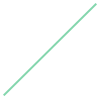

In [61]:
BuildingGeoSeries = BuildingData['geometry'][BuildingData['Theme'] == 'Buildings']
BuildingGeoSeries = BuildingGeoSeries.to_crs(27700)
BuildingDistances = BuildingGeoSeries.distance(Point(X,Y))
LineDistances = BuildingGeoSeries.shortest_line(Point(X,Y))
LineDistances.iloc[0]

In [62]:
import math


def calculate_initial_compass_bearing(pointA, pointB):
    if (type(pointA) != tuple) or (type(pointB) != tuple):
        raise TypeError("Only tuples are supported as arguments")

    lat1 = math.radians(pointA[0])
    lat2 = math.radians(pointB[0])

    diffLong = math.radians(pointB[1] - pointA[1])

    x = math.sin(diffLong) * math.cos(lat2)
    y = math.cos(lat1) * math.sin(lat2) - (math.sin(lat1)
            * math.cos(lat2) * math.cos(diffLong))

    initial_bearing = math.atan2(x, y)

    # Now we have the initial bearing but math.atan2 return values
    # from -180° to + 180° which is not what we want for a compass bearing
    # The solution is to normalize the initial bearing as shown below
    initial_bearing = math.degrees(initial_bearing)
    compass_bearing = (initial_bearing + 360) % 360

    return compass_bearing

calculate_initial_compass_bearing((X,Y),(LineDistances.iloc[0].coords[0][0],LineDistances.iloc[0].coords[0][1]))


207.97114988688537

In [63]:
map = BuildingData.explore('RelH2')
lon, lat = convert_lonlat(X,Y)
folium.Marker([lat[0], lon[0]],popup=[lat[0],lon[0]]).add_to(map)
folium.plugins.MeasureControl().add_to(map)

geo_j = folium.GeoJson(data=LineDistances, name="LineDistances", style_function=lambda x: {'color': 'red', 'weight': 1, 'opacity':0.5})
# folium.Popup(r["BoroName"]).add_to(geo_j)
geo_j.add_to(map)
map